In [1]:
import intake
import dask

In [2]:
#!/usr/bin/env python
from __future__ import print_function
import requests
import xml.etree.ElementTree as ET
import numpy

# Author: Unknown
# I got the original version from a word document published by ESGF
# https://docs.google.com/document/d/1pxz1Kd3JHfFp8vR2JCVBfApbsHmbUQQstifhGNdc6U0/edit?usp=sharing

# API AT: https://github.com/ESGF/esgf.github.io/wiki/ESGF_Search_REST_API#results-pagination

def esgf_search(server="https://esgf-node.llnl.gov/esg-search/search",
                files_type="OPENDAP", local_node=True, project="CMIP6",
                verbose=False, format="application%2Fsolr%2Bjson",
                use_csrf=False, **search):
    client = requests.session()
    payload = search
    payload["project"] = project
    payload["type"]= "File"
    if local_node:
        payload["distrib"] = "false"
    if use_csrf:
        client.get(server)
        if 'csrftoken' in client.cookies:
            # Django 1.6 and up
            csrftoken = client.cookies['csrftoken']
        else:
            # older versions
            csrftoken = client.cookies['csrf']
        payload["csrfmiddlewaretoken"] = csrftoken

    payload["format"] = format

    offset = 0
    numFound = 10000
    all_files = []
    files_type = files_type.upper()
    while offset < numFound:
        payload["offset"] = offset
        url_keys = []
        for k in payload:
            url_keys += ["{}={}".format(k, payload[k])]

        url = "{}/?{}".format(server, "&".join(url_keys))
        # print(url)
        r = client.get(url)
        r.raise_for_status()
        resp = r.json()["response"]
        numFound = int(resp["numFound"])
        resp = resp["docs"]
        offset += len(resp)
        for d in resp:
            if verbose:
                for k in d:
                    print("{}: {}".format(k,d[k]))
            url = d["url"]
            for f in d["url"]:
                sp = f.split("|")
                if sp[-1] == files_type:
                    all_files.append(sp[0].split(".html")[0])
    return sorted(all_files)

In [3]:
import xarray as xr

In [4]:
model_names = ['BCC-ESM1',
               'CESM2','CESM2-WACCM','CESM2-WACCM-FV2',
               'GISS-E2-1-H',
               'HADGEM3-GC31-LL', 'HADGEM3-GC31-MM',
               'IPSL-CM6A-LR',
               'MRI-ESM2-0']

In [5]:
def strip_data(data):
    
    ds = data.sel(time = slice('2011-01-01','2020-01-01'))
    ds = ds.where(ds.lat > 50).dropna(dim='time')
    
    return ds

In [6]:
def gather_from_archive(model_name, experiment):
    
    result = esgf_search(activity_id='CMIP', source_id=model_name, table_id='SIday', variable_id='sithick', experiment_id=experiment, member_id="r1i1p1f1")
    tag = []
    if len(result) == 0:
        print('There are no files for the model requested. Exiting...')
        sys.exit()
    else:
        for file in result:
            if file[7:21] != 'aims3.llnl.gov':
                result.remove(file)
        if len(result) > 1:
            print('Multiple files for model ', model_name)
            data = xr.open_mfdataset(result, combine = 'by_coords')
        else:
            data = xr.open_dataset(result[-1])
    return data

In [7]:
data = gather_from_archive('CESM2', 'historical')

/glade/u/home/mollyw/.conda/envs/cmip6/lib/python3.8/site-packages/xarray/conventions.py:523: SerializationWarning: variable 'sithick' has multiple fill values {1e+20, 1e+20}, decoding all values to NaN.
  new_vars[k] = decode_cf_variable(


In [10]:
data

<xarray.Dataset>
Dimensions:    (ni: 320, nj: 384, time: 60225, d2: 2, nvertices: 4)
Coordinates:
  * ni         (ni) int32 1 2 3 4 5 6 7 8 9 ... 313 314 315 316 317 318 319 320
  * nj         (nj) int32 1 2 3 4 5 6 7 8 9 ... 377 378 379 380 381 382 383 384
  * time       (time) object 1850-01-02 00:00:00 ... 2015-01-01 00:00:00
    lat        (nj, ni) float64 -79.22 -79.22 -79.22 ... 9.969e+36 9.969e+36
    lon        (nj, ni) float64 ...
Dimensions without coordinates: d2, nvertices
Data variables:
    time_bnds  (time, d2) object 1850-01-01 00:00:00 ... 2015-01-01 00:00:00
    lat_bnds   (nj, ni, nvertices) float32 -79.49 -79.49 ... 9.969e+36 9.969e+36
    lon_bnds   (nj, ni, nvertices) float32 320.0 321.1 ... 9.969e+36 9.969e+36
    sithick    (time, nj, ni) float32 ...
Attributes: (12/46)
    Conventions:                     CF-1.7 CMIP-6.2
    activity_id:                     CMIP
    case_id:                         15
    cesm_casename:                   b.e21.BHIST.f09_g17.CMIP6-historical.001
    contact:                         cesm_cmip6@ucar.edu
    creation_date:                   2019-01-16T22:08:06Z
    ...                              ...
    sub_experiment_id:               none
    branch_time_in_parent:           219000.0
    branch_time_in_child:            674885.0
    branch_method:                   standard
    further_info_url:                https://furtherinfo.es-doc.org/CMIP6.NCA...
    DODS_EXTRA.Unlimited_Dimension:  time

In [ ]:
ds = strip_data(data)

In [3]:
result = esgf_search(activity_id='CMIP', source_id="CESM2-WACCM", table_id='SIday', variable_id='sithick', experiment_id='historical', member_id="r1i1p1f1")
result

https://esgf-node.llnl.gov/esg-search/search/?activity_id=CMIP&source_id=CESM2-WACCM&table_id=SIday&variable_id=sithick&experiment_id=historical&member_id=r1i1p1f1&project=CMIP6&type=File&distrib=false&format=application%2Fsolr%2Bjson&offset=0


['http://aims3.llnl.gov/thredds/dodsC/css03_data/CMIP6/CMIP/NCAR/CESM2-WACCM/historical/r1i1p1f1/SIday/sithick/gn/v20190227/sithick_SIday_CESM2-WACCM_historical_r1i1p1f1_gn_18500102-20150101.nc',
 'http://esgf-data.ucar.edu/thredds/dodsC/esg_dataroot/CMIP6/CMIP/NCAR/CESM2-WACCM/historical/r1i1p1f1/SIday/sithick/gn/v20190227/sithick_SIday_CESM2-WACCM_historical_r1i1p1f1_gn_18500102-20150101.nc']

In [4]:
for file in result:
    if file[7:21] != 'aims3.llnl.gov':
        result.remove(file)

In [5]:
resulthttp://aims3.llnl.gov/thredds/dodsC/css03_data/CMIP6/CMIP/NCAR/CESM2-WACCM/historical/r1i1p1f1/SIday/sithick/gn/v20190227/sithick_SIday_CESM2-WACCM_historical_r1i1p1f1_gn_18500102-20150101.nc

['http://aims3.llnl.gov/thredds/dodsC/css03_data/CMIP6/CMIP/NCAR/CESM2-WACCM/historical/r1i1p1f1/SIday/sithick/gn/v20190227/sithick_SIday_CESM2-WACCM_historical_r1i1p1f1_gn_18500102-20150101.nc']

In [9]:
files_to_open = result[-1]

ds2 = xr.open_dataset(files_to_open)
ds2

/glade/u/home/mollyw/.conda/envs/cmip6/lib/python3.8/site-packages/xarray/conventions.py:523: SerializationWarning: variable 'sithick' has multiple fill values {1e+20, 1e+20}, decoding all values to NaN.
  new_vars[k] = decode_cf_variable(


<xarray.Dataset>
Dimensions:    (ni: 320, nj: 384, time: 60225, d2: 2, nvertices: 4)
Coordinates:
  * ni         (ni) int32 1 2 3 4 5 6 7 8 9 ... 313 314 315 316 317 318 319 320
  * nj         (nj) int32 1 2 3 4 5 6 7 8 9 ... 377 378 379 380 381 382 383 384
  * time       (time) object 1850-01-02 00:00:00 ... 2015-01-01 00:00:00
    lat        (nj, ni) float64 ...
    lon        (nj, ni) float64 ...
Dimensions without coordinates: d2, nvertices
Data variables:
    time_bnds  (time, d2) object ...
    lat_bnds   (nj, ni, nvertices) float32 ...
    lon_bnds   (nj, ni, nvertices) float32 ...
    sithick    (time, nj, ni) float32 ...
Attributes: (12/46)
    Conventions:                     CF-1.7 CMIP-6.2
    activity_id:                     CMIP
    case_id:                         4
    cesm_casename:                   b.e21.BWHIST.f09_g17.CMIP6-historical-WA...
    contact:                         cesm_cmip6@ucar.edu
    creation_date:                   2019-01-30T23:20:21Z
    ...                              ...
    variant_info:                    CMIP6 CESM2 hindcast (1850-2014) with hi...
    variant_label:                   r1i1p1f1
    branch_time_in_parent:           20075.0
    branch_time_in_child:            674885.0
    branch_method:                   standard
    DODS_EXTRA.Unlimited_Dimension:  time

In [48]:
http://esgf-data.ucar.edu/thredds/dodsC/esg_dataroot/CMIP6/CMIP/NCAR/CESM2-WACCM/historical/r1i1p1f1/SIday/sithick/gn/v20190227/sithick_SIday_CESM2-WACCM_historical_r1i1p1f1_gn_18500102-20150101.nctag = []
for file in result:
    tag.append(file[7:21])

In [55]:
tag

['aims3.llnl.gov', 'esgf-data.ucar']

In [4]:
import xarray as xr

In [35]:
ds2["model"] = 'CESM2-WACCM'

In [36]:
ds2 = ds2.assign_coords({'model':'CESM2-WACCM'})

In [39]:
ds2 = ds2.sel(time = slice('2011-01-01', '2020-01-01'))

In [26]:
ds

<xarray.Dataset>
Dimensions:    (ni: 320, nj: 384, time: 1461, d2: 2, nvertices: 4)
Coordinates:
  * ni         (ni) int32 1 2 3 4 5 6 7 8 9 ... 313 314 315 316 317 318 319 320
  * nj         (nj) int32 1 2 3 4 5 6 7 8 9 ... 377 378 379 380 381 382 383 384
  * time       (time) object 2011-01-01 00:00:00 ... 2015-01-01 00:00:00
    lat        (nj, ni) float64 ...
    lon        (nj, ni) float64 ...
    model      <U5 'CESM2'
Dimensions without coordinates: d2, nvertices
Data variables:
    time_bnds  (time, d2) object 2010-12-31 00:00:00 ... 2015-01-01 00:00:00
    lat_bnds   (nj, ni, nvertices) float32 -79.49 -79.49 ... 9.969e+36 9.969e+36
    lon_bnds   (nj, ni, nvertices) float32 320.0 321.1 ... 9.969e+36 9.969e+36
    sithick    (time, nj, ni) float32 ...
Attributes: (12/46)
    Conventions:                     CF-1.7 CMIP-6.2
    activity_id:                     CMIP
    case_id:                         15
    cesm_casename:                   b.e21.BHIST.f09_g17.CMIP6-historical.001
    contact:                         cesm_cmip6@ucar.edu
    creation_date:                   2019-01-16T22:08:06Z
    ...                              ...
    sub_experiment_id:               none
    branch_time_in_parent:           219000.0
    branch_time_in_child:            674885.0
    branch_method:                   standard
    further_info_url:                https://furtherinfo.es-doc.org/CMIP6.NCA...
    DODS_EXTRA.Unlimited_Dimension:  time

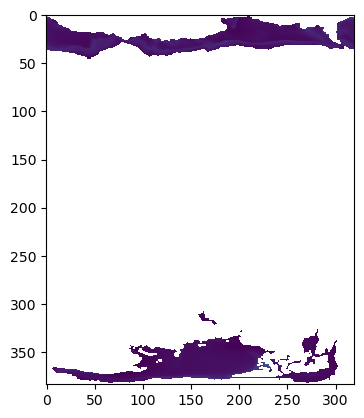

In [29]:
plt.imshow(ds.sithick.isel(time=0))

In [28]:
import matplotlib.pyplot as plt

In [40]:
ds2 = ds2.sel(nj = slice(300, 400))

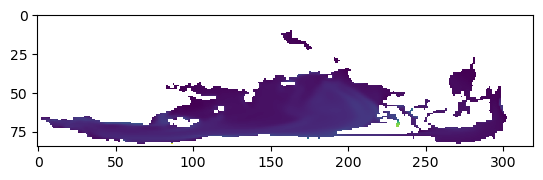

In [41]:
plt.imshow(ds2.sithick.isel(time=0))

In [42]:
ds2

<xarray.Dataset>
Dimensions:    (ni: 320, nj: 85, time: 1461, d2: 2, nvertices: 4)
Coordinates:
  * ni         (ni) int32 1 2 3 4 5 6 7 8 9 ... 313 314 315 316 317 318 319 320
  * nj         (nj) int32 300 301 302 303 304 305 ... 379 380 381 382 383 384
  * time       (time) object 2011-01-01 00:00:00 ... 2015-01-01 00:00:00
    lat        (nj, ni) float64 ...
    lon        (nj, ni) float64 ...
    model      <U11 'CESM2-WACCM'
Dimensions without coordinates: d2, nvertices
Data variables:
    time_bnds  (time, d2) object ...
    lat_bnds   (nj, ni, nvertices) float32 ...
    lon_bnds   (nj, ni, nvertices) float32 ...
    sithick    (time, nj, ni) float32 ...
Attributes: (12/46)
    Conventions:                     CF-1.7 CMIP-6.2
    activity_id:                     CMIP
    case_id:                         4
    cesm_casename:                   b.e21.BWHIST.f09_g17.CMIP6-historical-WA...
    contact:                         cesm_cmip6@ucar.edu
    creation_date:                   2019-01-30T23:20:21Z
    ...                              ...
    variant_info:                    CMIP6 CESM2 hindcast (1850-2014) with hi...
    variant_label:                   r1i1p1f1
    branch_time_in_parent:           20075.0
    branch_time_in_child:            674885.0
    branch_method:                   standard
    DODS_EXTRA.Unlimited_Dimension:  time

In [44]:
DS = xr.concat([ds, ds2], dim = 'model')

In [45]:
DS

<xarray.Dataset>
Dimensions:    (ni: 320, nj: 85, time: 1461, model: 2, d2: 2, nvertices: 4)
Coordinates:
  * ni         (ni) int32 1 2 3 4 5 6 7 8 9 ... 313 314 315 316 317 318 319 320
  * nj         (nj) int32 300 301 302 303 304 305 ... 379 380 381 382 383 384
  * time       (time) object 2011-01-01 00:00:00 ... 2015-01-01 00:00:00
    lat        (model, nj, ni) float64 38.71 38.71 38.72 ... 9.969e+36 9.969e+36
    lon        (model, nj, ni) float64 320.6 321.7 322.8 ... 9.969e+36 9.969e+36
  * model      (model) <U11 'CESM2' 'CESM2-WACCM'
Dimensions without coordinates: d2, nvertices
Data variables:
    time_bnds  (model, time, d2) object 2010-12-31 00:00:00 ... 2015-01-01 00...
    lat_bnds   (model, nj, ni, nvertices) float32 38.5 38.5 ... 9.969e+36
    lon_bnds   (model, nj, ni, nvertices) float32 320.0 321.1 ... 9.969e+36
    sithick    (model, time, nj, ni) float32 nan nan nan nan ... nan nan nan nan
Attributes: (12/46)
    Conventions:                     CF-1.7 CMIP-6.2
    activity_id:                     CMIP
    case_id:                         15
    cesm_casename:                   b.e21.BHIST.f09_g17.CMIP6-historical.001
    contact:                         cesm_cmip6@ucar.edu
    creation_date:                   2019-01-16T22:08:06Z
    ...                              ...
    sub_experiment_id:               none
    branch_time_in_parent:           219000.0
    branch_time_in_child:            674885.0
    branch_method:                   standard
    further_info_url:                https://furtherinfo.es-doc.org/CMIP6.NCA...
    DODS_EXTRA.Unlimited_Dimension:  time